In [9]:
%matplotlib inline

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1차원 칼만 필터
## 과정
우리가 다룰 estimation은 다음과 같이 진행됩니다.

0. 초기화 과정에서 initial stae 등의 값을 주어줍니다.

1. 시스템에 대한 식에 기반해 다음 time step에서의 시스템의 상태를 예측합니다. (Prediction step)

2. 측정값을 받아 예측한 상태를 업데이트해줍니다. (Measurement update)

 이 과정들에 대해 1차원 예제부터 출발해 multi-dimensional 예제로 확장해보도록 하겠습니다. 
 


## Gaussian 함수
 교과서에서는 이 과정들을 설명하기 위해 1차원 공간에서 움직이는 강아지의 위치를 추정하는 예제를 다루었습니다. 
 
 교과서의 이전 절에서 다루었던 discriete bayes filter의 경우, 강아지의 위치를 0~9 사이의 정수로 표현을 하였으나 우리는 불확실한 강아지의 위치를 gaussian 함수의 형태로 표현할 수도 있습니다.
 
 예를 들어, 강아지가 10m에 있으나 그 위치가 불확실해서 위치에 대한 분산이 1$m^2$라고 합시다. 이 경우, 흔히 사용되는 gaussian 분포로는 다음과 같은 표현이 가능합니다.; $N(10, 1)$
 
 그 분포를 파이썬의 numpy와 scipy를 이용해 나타낸다면 다음과 같습니다.

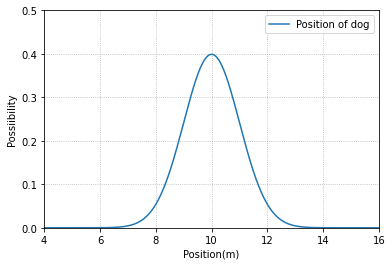

In [69]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

mu, sigma = 10, 1
x = np.linspace(mu - 10*sigma, mu + 10*sigma, 10000)
gaussian = stats.norm.pdf(x, mu, sigma)
    
plt.plot(x, gaussian, label = 'Position of dog')

plt.grid(linestyle='dotted', linewidth=0.8)
plt.xlabel('Position(m)')
plt.ylabel('Possiibility')
plt.xlim([4, 16])
plt.ylim([0, 0.5])
plt.legend()
plt.show()

  이 normal distribution에서 알 수 있듯이, 우리가 측정하고자 하는 개의 위치는 정확히 정해져있지 않습니다. 분포 상에서 9~11m 정도에 위치해있을 확률이 가장 높다고는 하나 강아지는 다른 위치에 있을 수도 있습니다. 
  
  해당 분포를 따르는 강아지의 위치를 측정해오는 코드를 작성해봅시다.

Mean of sensor reading is  9.975131631786178


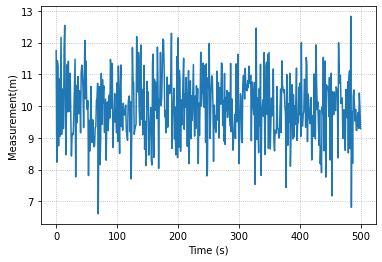

In [55]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = randn(500)*1 + 10

plt.grid(linestyle='dotted', linewidth=0.8)
plt.plot(xs, ys)
plt.xlabel('Time (s)')
plt.ylabel('Measurement(m)')

print(f'Mean of sensor reading is ', np.mean(ys))

  코드를 여러번 돌려보시면 아실 수 있다시피 print 되어지는 평균값은 계속해서 바뀜을 알 수 있습니다. 사실 어떤 강아지나 동물도 이렇게 움직이지는 않습니다. 
  
  완벽한 센서는 존재할 수 없기 때문에 강아지가 가만히 서있다는 가정 하에 위치가 10m 정도이며 그 분산이 1인 것입니다.
  


## Prediction (sum of gaussian)
 우리는 강아지의 위치를 뉴턴 운동방정식을 기반으로 이전 step의 위치와 현재 속도를 기반으로 현재 step의 위치를 계산해보도록 하겠습니다. 그럼 식은 다음과 같을 것입니다.
$$\begin{aligned}\bar{x}_k = x_{k-1}+v_k \delta t \\ 
  = x_{k-1}+f_x\end{aligned}$$

 현재의 강아지의 위치가 10m이며 속도가 15m/s인데 time step size가 2초 정도라면 다음 강아지의 위치는 다음과 같을 것입니다.
$$
\begin{aligned}
f_x = v \centerdot\delta t = 15\centerdot2
\\ \bar{x}_k = 10+(15\centerdot 2) = 40
\end{aligned}
$$
이렇게 위치를 표현하는 일은 가능하지만 강아지의 위치가 불확실하다는 것은 어떻게 표현할 수 있을까요? 
 이는 sum of gaussian이라는 gaussian 함수의 성질을 이용해 표현할 수 있습니다.

$$\begin{aligned}\mu = \mu_1 + \mu_2 \\
 \sigma^2 = \sigma_1^2+\sigma_2^2 \end{aligned}$$
 
 예를 들어서 우리에서 주어진 위치에 대한 분포(식의 x), 속도에 대한 분포(식의 $f_x$)가 다음과 같다고 하겠습니다. 아래 두 식을 이용해 3, 4번째 줄의 식을 얻을 수 있습니다
 
 $$\begin{aligned}x =N(10,0.2^2) \\ f_x = N(15, 0.7^2) \end{aligned}\\$$
$$ \begin{aligned} \bar{x} = \mu_x = \mu_{f_x} = 10+15 = 25\\
 \bar{\sigma}^2 = \sigma_x^2+\sigma_{f_x}^2 = 0.2^2+0.7^2 = 0.53
 \end{aligned}$$
 
  그 분포를 그린다면 다음고 ㅏ같은 결과를 얻을 수 있습니다. 

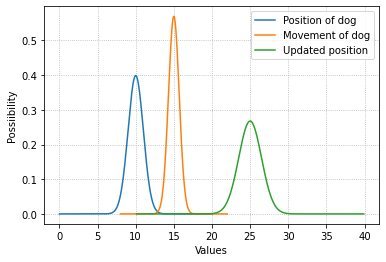

Updated mean:  25  Updated variance:  1.49


In [72]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

mu1, sigma1 = 10, 1
mu2 , sigma2 = 15, 0.7
# Calculate updated state! 
mu3 = mu1+ mu2
sigma3 = sigma1**2+sigma2**2

x = np.linspace(mu1-10*sigma1, mu1+10*sigma1, 10000)
z = np.linspace(mu2-10*sigma2, mu2+10*sigma2, 10000)
y = np.linspace(mu3-10*sigma3, mu3+10*sigma3, 10000)

pos1 = stats.norm.pdf(x, mu1, sigma1)
vel1 = stats.norm.pdf(z, mu2, sigma2)    
pos2 = stats.norm.pdf(y, mu3, sigma3)

plt.plot(x, pos1, label = 'Position of dog')
plt.plot(z, vel1, label = 'Movement of dog')
plt.plot(y, pos2, label = 'Updated position')
plt.grid(linestyle='dotted', linewidth=0.8)
plt.xlabel('Values')
plt.ylabel('Possiibility')

plt.legend()
plt.show()

print("Updated mean: ",mu3, " Updated variance: ", sigma3)

## Update with gaussian (Product of gaussian)

$$ \begin{aligned}
x = \lVert \mathcal L \bar{x} \rVert
\end{aligned} $$

 위 식에서 likelihood, $\mathcal L$은 측정값의 확률에 대한 확률이다. 예를 들어서, 센서에서 읽히는 강아지의 위치가 23m이며 분산 값이 0.4m라면 우리의 축정값은 likelihood로 다음고 같이 주어질 수 있다.: $z = \mathcal N(23, 0.16)$
 
  이런 경우엔 첫번째 식과 같이 product of gaussian으로 나타낼 수 있다. 자세한 증명은 아래를 참조하도록 하자. 해당 식은 다음과 같다.
  
  $$\begin{aligned}
  \mu = {{\sigma_1^2\mu_2+\sigma_2^2\mu_1}\over{\sigma_1^2+\sigma_2^2}},\\
  \sigma^2 = {{\sigma_1^2\sigma_2^2}\over{\sigma_1^2+\sigma_2^2}}
  \end{aligned}$$
  
 여기서 우리가 알 수 있는 사실은 새로운 분산은 prior에 대한 분산과 측정 값의 분산으로만 이루어진다는 것이다.
 
 아래의 예제 코드는 product of gaussian이 갖는 의미를 보여주고자 구현된 코드이다. 

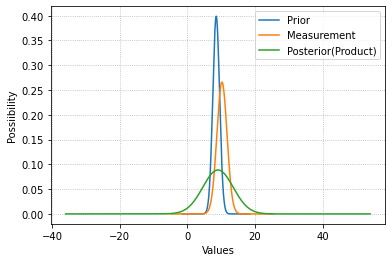

Updated mean:  9.023076923076923  Updated variance:  4.5


In [80]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

def gaussian_product(m1, m2, v1, v2):
    """
    Function defined for gaussian product
    Args:
        m1: mean of prior
        m2: mean of measurement
        v1: variance of prior
        v2: variance of measurement
    Output:
        m: mean of posterior
        v: variance of posterior
    """
    m = (m2*v1**2+m1*v2**2)/(v1**2+v2**2)
    v = (v1**2*v2**2)/v1**2+v2**2
    
    return m, v

mu1, sigma1 = 8.5, 1
mu2 , sigma2 = 10.2, 1.5
# Calculate updated state! 
mu3, sigma3 = gaussian_product(mu1, mu2, sigma1, sigma2)

x = np.linspace(mu1-10*sigma1, mu1+10*sigma1, 10000)
z = np.linspace(mu2-10*sigma2, mu2+10*sigma2, 10000)
y = np.linspace(mu3-10*sigma3, mu3+10*sigma3, 10000)

pos1 = stats.norm.pdf(x, mu1, sigma1)
vel1 = stats.norm.pdf(z, mu2, sigma2)    
pos2 = stats.norm.pdf(y, mu3, sigma3)

plt.plot(x, pos1, label = 'Prior')
plt.plot(z, vel1, label = 'Measurement')
plt.plot(y, pos2, label = 'Posterior(Product)')
plt.grid(linestyle='dotted', linewidth=0.8)
plt.xlabel('Values')
plt.ylabel('Possiibility')

plt.legend()
plt.show()

print("Updated mean: ",mu3, " Updated variance: ", sigma3)

## Implementation of 1-dimensional kalman filter
적절한 초깃값을 주어주고 update와 measurement update 과정을 반복한다면 우리는 칼만 필터를 구현할 수 있습니다! 그럼 코드로 살펴보도록 하겠습니다,,,

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

def state_update(p1, v1, pv1, vv1, dt):
    """
    Function defined for state update
    - Args:
        p1: state of position
        v1: velocity of dog set as 1
        pv1: variance of position
        vv1: variance of velocity
        dt: delta t
    - Output:
        xbar = updated state
        vbar = updated variance
    """
    xbar = p1+v1*dt
    vbar = pv1**2 + vv1**2

def gaussian_product(m1, m2, v1, v2):
    """
    Function defined for gaussian product
    Args:
        m1: mean of prior
        m2: mean of measurement
        v1: variance of prior
        v2: variance of measurement
    Output:
        m: mean of posterior
        v: variance of posterior
    """
    m = (m2*v1**2+m1*v2**2)/(v1**2+v2**2)
    v = (v1**2*v2**2)/v1**2+v2**2
    
    return m, v

pos_ini = 0
pv_ini = 20

vel = 1
dt = 1

for i in range(1, 1000):
    if i == 0:
        xbar = pos_ini
        vbar = pv_ini
    else:
        # state update
        
        # measurement update
    

mu1, sigma1 = 8.5, 1
mu2 , sigma2 = 10.2, 1.5
# Calculate updated state! 
mu3, sigma3 = gaussian_product(mu1, mu2, sigma1, sigma2)

x = np.linspace(mu1-10*sigma1, mu1+10*sigma1, 10000)
z = np.linspace(mu2-10*sigma2, mu2+10*sigma2, 10000)
y = np.linspace(mu3-10*sigma3, mu3+10*sigma3, 10000)

pos1 = stats.norm.pdf(x, mu1, sigma1)
vel1 = stats.norm.pdf(z, mu2, sigma2)    
pos2 = stats.norm.pdf(y, mu3, sigma3)

plt.plot(x, pos1, label = 'Prior')
plt.plot(z, vel1, label = 'Measurement')
plt.plot(y, pos2, label = 'Posterior(Product)')
plt.grid(linestyle='dotted', linewidth=0.8)
plt.xlabel('Values')
plt.ylabel('Possiibility')

plt.legend()
plt.show()

print("Updated mean: ",mu3, " Updated variance: ", sigma3)

### Sum of gaussian의 증명 과정
$\begin{array}{l}
p(x)=\int_{-\infty}^{\infty} f_{2}\left(x-x_{1}\right) f_{1}\left(x_{1}\right) d x \\
=\int_{-\infty}^{\infty} \frac{1}{\sqrt{2 \pi} \sigma_{z}} \exp \left[-\frac{\left(x-z-\mu_{z}\right)^{2}}{2 \sigma_{z}^{2}}\right] \frac{1}{\sqrt{2 \pi} \sigma_{p}} \exp \left[-\frac{\left(x-\mu_{p}\right)^{2}}{2 \sigma_{\rho}^{2}}\right] d x \\
=\frac{1}{\sqrt{2 \pi} \sqrt{\sigma_{p}^{2}+\sigma_{z}^{2}}} \exp \left[-\frac{\left.\left(x-\left(\mu_{p}+\mu_{z}\right)\right)\right)^{2}}{2\left(\sigma_{z}^{2}+\sigma_{p}^{2}\right)}\right] \int_{-\infty}^{\infty} \frac{1}{\sqrt{2 \pi} \frac{\sigma_{\rho \sigma z}}{\sqrt{\sigma_{p}^{2}+\sigma_{2}^{2}}}} \exp \left[-\frac{\left.\left(x-\frac{\sigma_{\rho}^{2}\left(x-\mu_{z}\right)+\sigma_{\tilde{z}}^{2} \mu_{p}}{\partial}\right)\right)^{2}}{2\left(\frac{\sigma_{p} \sigma_{x}}{\sqrt{\sigma_{z}^{2}+\sigma_{p}^{2}}}\right)^{2}}\right] d x
\end{array}$